In [1]:
### YOUR CODE HERE ###
# Импортируем необъодимые библиотеки
import sqlalchemy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Задча

Задача: сделать аналитический отчет по SMM-отдела компании Skillbox. <br> Объектом анализа является  [паблик Skillbox Вконтакте](https://vk.com/skillbox_education).

### 1. Выгрузка данных в DataFrame

In [1]:
import requests
import re
from datetime import datetime, timedelta
import pandas as pd

In [2]:
def getjson(url):
    response = requests.get(url)
    response = response.json()
    return response

In [20]:
vk_token = "????"

In [21]:
# получаем последнюю запись из паблика Skillbox Вконтакте
url = 'https://api.vk.com/method/wall.get?access_token=' + str(vk_token) + '&owner_id=-66669811&count=1&v=5.92'
response = getjson(url)

In [22]:
# Посмтрим, сколько записей на паблике Skillbox Вконтакте
count_record = response['response']['count']
print("В паблике Skillboks Вконтакте {} записей".format(count_record))

# Сохраним структуру датафрейма, чтобы в дальнейшем заполнить ее данными
df_response = pd.DataFrame(response['response']['items'])
df_response.drop(labels=[0], axis=0, inplace=True)

В паблике Skillboks Вконтакте 4028 записей


In [23]:
# Выгрузим все записи в датафрейм
# поскольку можно выгружать максимум по 100 записей, пройдемся по циклу
int_count_record = count_record // 100
rem_count_record = count_record % 100

# Будем добавлять в датафрейм по 100 записей, после прохождение цикла добавим оставшееся количество записей

for i in range(int_count_record):
    offset = i * 100
    url = 'https://api.vk.com/method/wall.get?access_token=' + str(vk_token) + \
          '&owner_id=-66669811&offset={}&count=100&v=5.92'.format(offset)
    
    response = getjson(url)
    
    df_response = df_response.append(response['response']["items"])
else:
    offset = int_count_record * 100
    url = 'https://api.vk.com/method/wall.get?access_token=' + str(vk_token) + \
    '&owner_id=-66669811&offset={offset}&count={rem_count_record}&v=5.92'.format(offset=offset, rem_count_record=rem_count_record)
    
    response = getjson(url)
    df_response = df_response.append(response["response"]["items"])

### 2. Подготовка датафрейма к анализу

In [24]:
df = df_response

# Преобразуем поле date к более привычному формату и добавим в отдельную колонку
f = lambda date: (datetime.fromtimestamp(date) - timedelta(hours=0)).strftime('%Y-%m-%d %H:%M:%S')
df["date_time"] = df["date"].apply(f)

In [25]:
# Выделим из поля likes количество лайков и добавим в отдельную колонку
f = lambda dict_likes: int(dict_likes["count"])
df["likes_count"] = df["likes"].apply(f)

In [26]:
# Выделим из поля comments количество комментариев и добавим в отдельную колонку
f = lambda dict_comments: int(dict_comments["count"])
df["comments_count"] = df["comments"].apply(f)

In [27]:
# Выделим из поля views количество просмотров и добавим в отдельную колонку
df["views"] = df["views"].fillna(0)

f = lambda dict_views: dict_views["count"] if dict_views != 0 else 0
df["views_count"] = df["views"].apply(f)

In [28]:
# Выделим из поля reposts количество репостов и добавим в отдельную колонку
f = lambda dict_comments: int(dict_comments["count"])
df["reposts_count"] = df["reposts"].apply(f)

In [29]:
# Добавим колонку с часом, в котором была совершена публикация поста
df["hour_posts"] = pd.to_datetime(df['date_time'].astype(str)).dt.hour
# Добавим колонку с днем, в котором была совершена публикация поста
df["day_posts"] = pd.to_datetime(df['date_time'].astype(str)).dt.day_of_week
# Добавим колонку с месяцем, в котором была совершена публикация поста
df["month_posts"] = pd.to_datetime(df['date_time'].astype(str)).dt.month
# Добавим колонку с годом, в котором была совершена публикация поста
df["year_posts"] = pd.to_datetime(df['date_time'].astype(str)).dt.year

In [30]:
# Напишем функцию которая будет возращать из поста рубрику к которой относится пост
def rubric(text):
    pattern = re.compile(r"#Skillbox_\w+")
    rubric = pattern.findall(text)
    if rubric:
        return rubric[0].lower()
    return '#no_rubric'

df["rubric"] = df.text.apply(rubric)

In [31]:
# Выгруженные данные для анализа
df.head(3)

,id,from_id,owner_id,date,marked_as_ads,post_type,text,is_pinned,attachments,post_source,...,date_time,likes_count,comments_count,views_count,reposts_count,hour_posts,day_posts,month_posts,year_posts,rubric
0,215343,-66669811,-66669811,1635762751,0,post,"Нет, это не шутка! Попробовать 34 курса и инте...",1.0,"[{'type': 'photo', 'photo': {'album_id': -7, '...",{'type': 'vk'},...,2021-11-01 13:32:31,721,219,110031,1172,13,0,11,2021,#no_rubric
1,234514,-66669811,-66669811,1645603885,0,post,"Когда вы готовитесь к собеседованию, мало отре...",NaN,"[{'type': 'photo', 'photo': {'album_id': -7, '...",{'type': 'api'},...,2022-02-23 11:11:25,65,0,15636,63,11,2,2,2022,#no_rubric
2,234464,-66669811,-66669811,1645516836,0,post,"Единственная веская причина, почему вам не сто...",NaN,"[{'type': 'photo', 'photo': {'album_id': -7, '...",{'type': 'api'},...,2022-02-22 11:00:36,19,0,9709,11,11,1,2,2022,#skillbox_маркетинг


In [32]:
# Посмотрим на структуру датафрейма
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4028 entries, 0 to 27
Data columns (total 28 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              4028 non-null   int64  
 1   from_id         4028 non-null   int64  
 2   owner_id        4028 non-null   int64  
 3   date            4028 non-null   int64  
 4   marked_as_ads   4028 non-null   int64  
 5   post_type       4028 non-null   object 
 6   text            4028 non-null   object 
 7   is_pinned       1 non-null      float64
 8   attachments     3960 non-null   object 
 9   post_source     4028 non-null   object 
 10  comments        4028 non-null   object 
 11  likes           4028 non-null   object 
 12  reposts         4028 non-null   object 
 13  views           4028 non-null   object 
 14  is_favorite     4028 non-null   bool   
 15  hash            4028 non-null   object 
 16  copy_history    44 non-null     object 
 17  signer_id       2 non-null      flo

### 3. Анализ данных

#### Проанализируем как время публикации влияет на вовлеченность пользователей

In [33]:
print("Первая запись в паблике появилась: {}".format(df.date_time.min()))
print("Последняя запись в паблике была сделана: {}".format(df.date_time.max()))

Первая запись в паблике появилась: 2016-04-01 11:38:31
Последняя запись в паблике была сделана: 2022-02-23 11:11:25


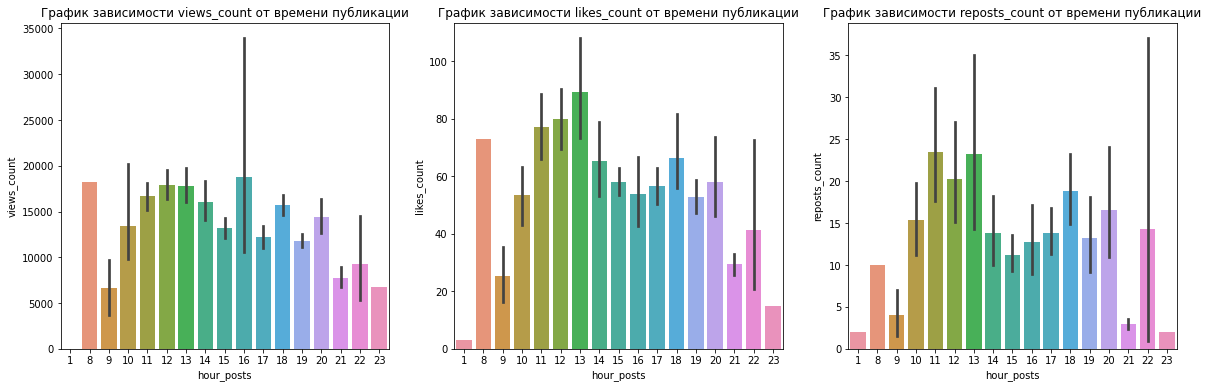

In [34]:
# Проанализируем, как время публикации поста влияет на вовлеченность пользователей.
# Возьмем для анализа данные за весь период, т.к. чем больше выборка, тем точнее расчеты.
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))

for i, col in enumerate(["views_count", "likes_count", "reposts_count"]):
    ax = axs[i]
    sns.barplot(data=df, x="hour_posts", y=col, ax=ax)
    ax.set_title("График зависимости {} от времени публикации".format(col))

plt.show()

#### Проанализируем, какие рубрики наиболее/наименее часто публикуются в паблике (за весь период)

In [35]:
# Посчитаем количество публикаций по рубрикам за весь период
rubric_count = df.groupby(["rubric"])["id"].agg("count").sort_values(ascending=False).reset_index()

# Оставим только те рубрики, которые использовались более 1 раза, 
# чтобы исключить тестовые рубрики и рубрики с ошибками в названии
rubric_count = rubric_count[rubric_count["id"] > 1]

# Посчитаем количество публикаций по рубрикам за весь период (ТОП)
rubric_top = rubric_count.sort_values("id", ascending=False).reset_index().head(6)
# Удалим первую строку, где указано количество публикаций без рубрики
rubric_top = rubric_top.drop(np.where(rubric_top['rubric'] == "#no_rubric")[0])

# Посчитаем количество публикаций по рубрикам за весь период (антиТОП)
rubric_bad = rubric_count.sort_values("id").reset_index().head(5)

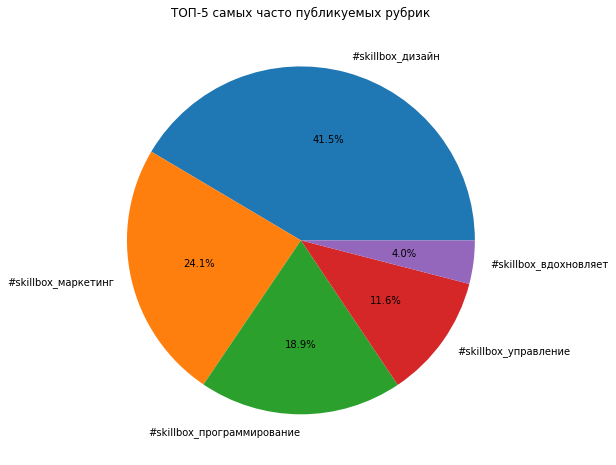

In [36]:
# Построим график ТОП-5 самых часто публикуемых рубрик
fig, ax = plt.subplots(figsize=(10, 8))
ax.pie(data=rubric_top, x=rubric_top["id"], labels=rubric_top.rubric, autopct='%1.1f%%')
ax.set_title("ТОП-5 самых часто публикуемых рубрик")
plt.show()

In [37]:
rubric_top.head()

,index,rubric,id
1,1,#skillbox_дизайн,319
2,2,#skillbox_маркетинг,185
3,3,#skillbox_программирование,145
4,4,#skillbox_управление,89
5,5,#skillbox_вдохновляет,31


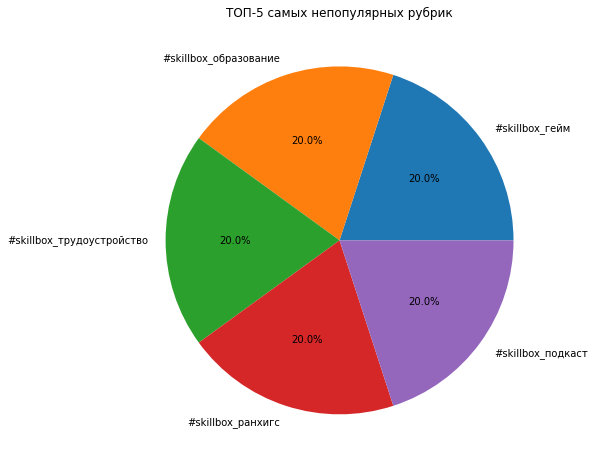

In [38]:
# Построим график антиТОП-5 самых часто публикуемых рубрик
fig, ax = plt.subplots(figsize=(10, 8))
ax.pie(data=rubric_bad, x=rubric_bad["id"], labels=rubric_bad.rubric, autopct='%1.1f%%')
ax.set_title("ТОП-5 самых непопулярных рубрик")
plt.show()

In [39]:
rubric_bad.head()

,index,rubric,id
0,26,#skillbox_гейм,2
1,24,#skillbox_образование,2
2,23,#skillbox_трудоустройство,2
3,22,#skillbox_ранхигс,2
4,21,#skillbox_подкаст,2


#### Проанализируем, какие рубрики наиболее/наименее часто публикуются в паблике (за последний год)

In [40]:
# Посчитаем количество публикаций по рубрикам за 2021 год
rubric_count = df[df["year_posts"] >= 2021]
rubric_count = rubric_count.groupby(["rubric"])["id"].agg("count").sort_values(ascending=False).reset_index()
# rubric_count = rubric_count[rubric_count[""]]

# Оставим только те рубрики, которые использовались более 1 раза, 
# чтобы исключить тестовые рубрики и рубрики с ошибками в названии
rubric_count = rubric_count[rubric_count["id"] > 1]

# Посчитаем количество публикаций по рубрикам за весь период (ТОП)
rubric_top = rubric_count.sort_values("id", ascending=False).reset_index().head(6)
# Удалим первую строку, где указано количество публикаций без рубрики
rubric_top = rubric_top.drop(np.where(rubric_top['rubric'] == "#no_rubric")[0])

# Посчитаем количество публикаций по рубрикам за весь период (антиТОП)
rubric_bad = rubric_count.sort_values("id").reset_index().head(5)

In [41]:
rubric_top

,index,rubric,id
1,1,#skillbox_дизайн,49
2,2,#skillbox_маркетинг,37
3,3,#skillbox_мультимедиа,28
4,4,#skillbox_программирование,23
5,5,#skillbox_управление,15


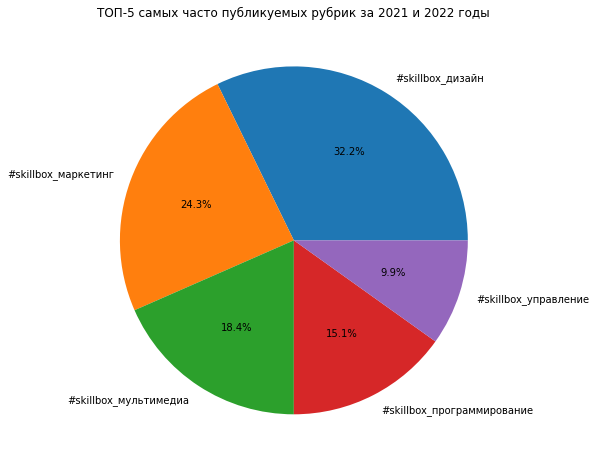

In [42]:
# Построим график ТОП-5 самых часто публикуемых рубрик
fig, ax = plt.subplots(figsize=(10, 8))
ax.pie(data=rubric_top, x=rubric_top["id"], labels=rubric_top.rubric, autopct='%1.1f%%')
ax.set_title("ТОП-5 самых часто публикуемых рубрик за 2021 и 2022 годы")
plt.show()

#### Проведем анализ по рубрикам, какие из рубрик являются наиболее вовлекающими (лайки, репосты, комменты)

In [43]:
# Оставим в датафрейме только те рубрики, которые попадают в ТОП-11
df_rubric_top = df.groupby("rubric").count()["id"].sort_values(ascending=False).reset_index().head(11)
# Удалим из датафрейма строку, в которой подсчитано количество постов без рубрик
df_rubric_top = df_rubric_top.drop(np.where(df_rubric_top["rubric"] == "#no_rubric")[0])

df_rubric_top = df[df["rubric"].isin(df_rubric_top.rubric)]

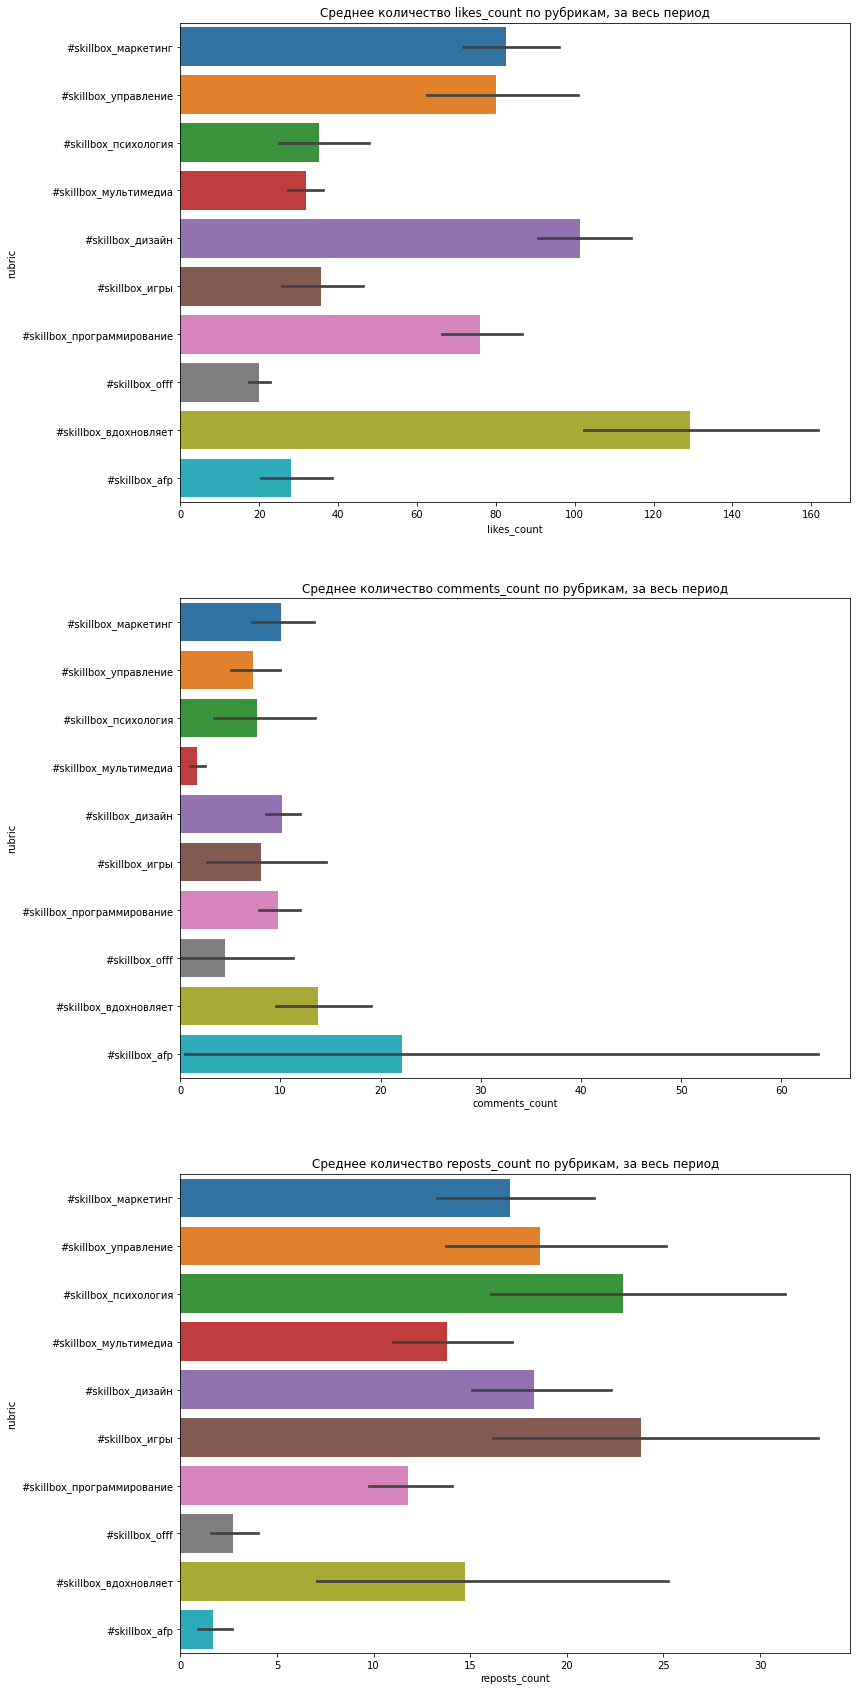

In [44]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(12, 30))
for i, col in enumerate(["likes_count", "comments_count", "reposts_count"]):
    ax = axs[i]
    sns.barplot(data=df_rubric_top, x=col, y="rubric", ax=ax)
    ax.set_title("Среднее количество {} по рубрикам, за весь период".format(col))
    
plt.show()

In [45]:
# Оставим в датафрейме только те рубрики, которые попадают в ТОП-11
df_rubric_top = df_rubric_top.groupby("rubric").count()["id"].sort_values(ascending=False).reset_index().head(11)

# Удалим из датафрейма строку, в которой подсчитано количество постов без рубрик
df_rubric_top = df_rubric_top.drop(np.where(df_rubric_top["rubric"] == "#no_rubric")[0])

df_rubric_top = df[df["rubric"].isin(df_rubric_top.rubric)]

# Отфильтруем датафрейм, чтобы в нем остались только записи за 2021 и 2022 годы
df_rubric_top = df_rubric_top[df_rubric_top["year_posts"] >= 2021]

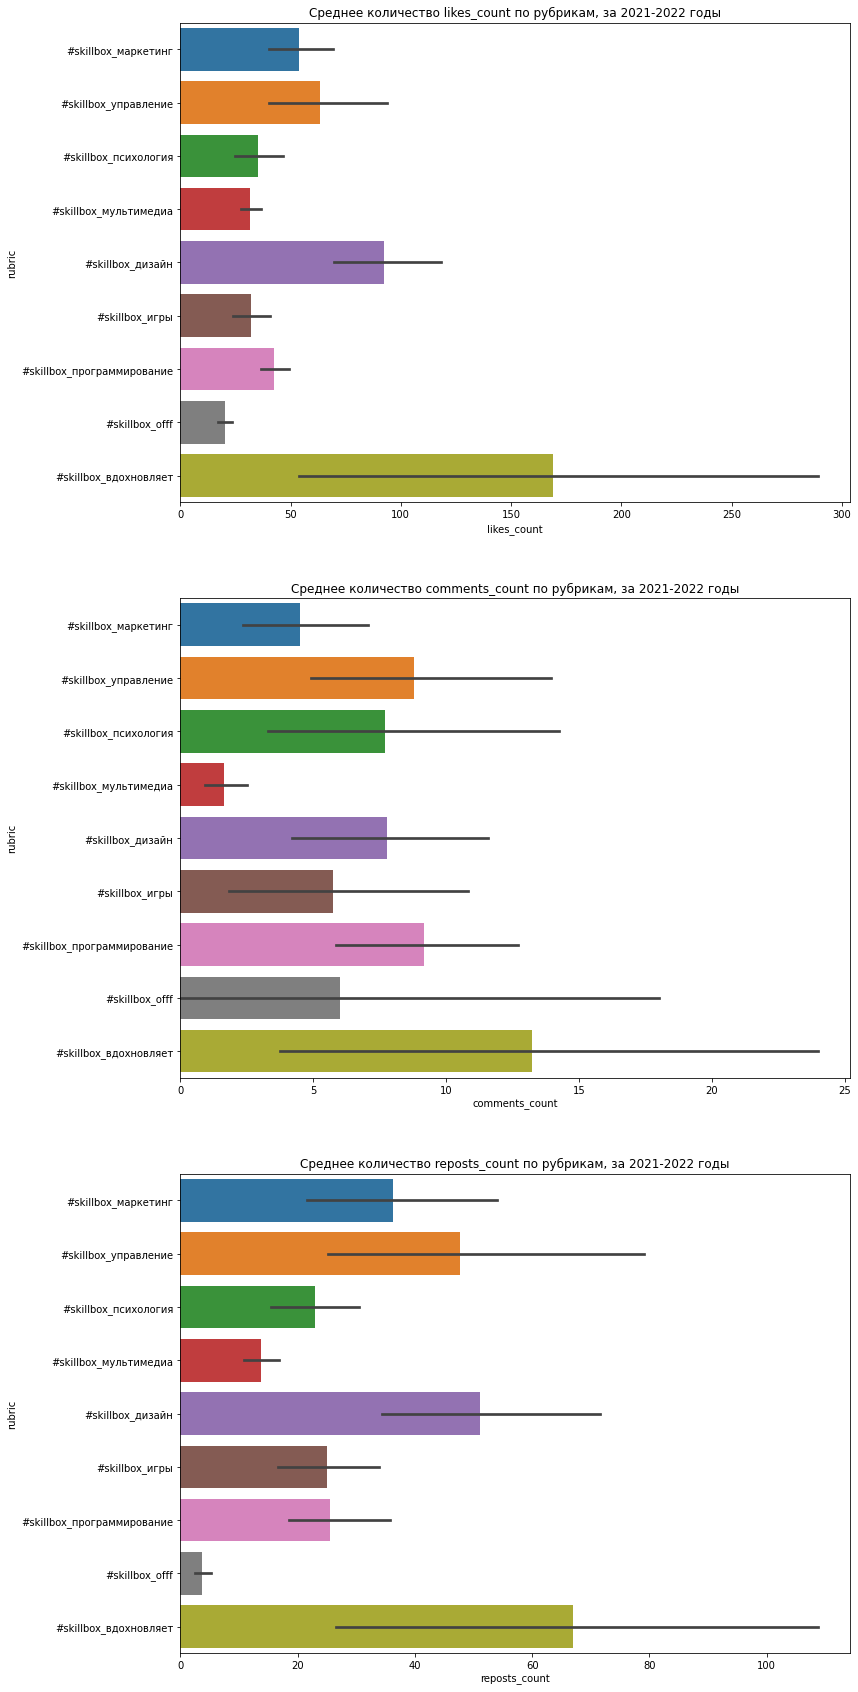

In [46]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(12, 30))
for i, col in enumerate(["likes_count", "comments_count", "reposts_count"]):
    ax = axs[i]
    sns.barplot(data=df_rubric_top, x=col, y="rubric", ax=ax)
    ax.set_title("Среднее количество {} по рубрикам, за 2021-2022 годы".format(col))
    
plt.show()

### Построим графики, отражающие общую тенденцию развития паблика Skillbox

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  after removing the cwd from sys.path.


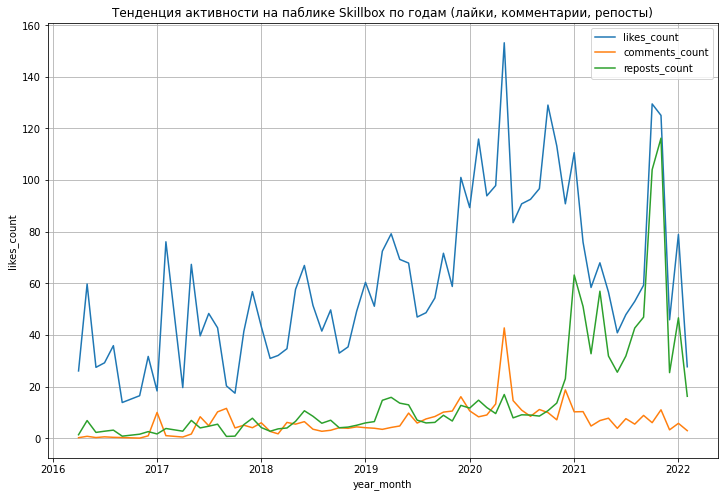

In [47]:
# Добавим в датафрейм колонку, которая будет содержать год и месяц публикации, чтобы построить график по усредненным значениям месяца
m = lambda x: pd.to_datetime(str(x[0])+'-'+str(x[1])+'-'+'01 '+'00:00:00')
df["year_month"] = df[["year_posts", "month_posts"]].apply(m, axis=1)
df_trend_like = df.groupby(["year_month"])["likes_count", "comments_count", "reposts_count"].agg("mean")

fig, ax = plt.subplots(figsize=(12, 8))
for col in df_trend_like.columns:
    sns.lineplot(data=df_trend_like, x=df_trend_like.index, y=col, label=col, ax=ax)

plt.legend()
plt.title("Тенденция активности на паблике Skillbox по годам (лайки, комментарии, репосты)")
plt.grid()
plt.show()

### Построим графики, отражающие количество постов по месяцам начиная с 2021 года

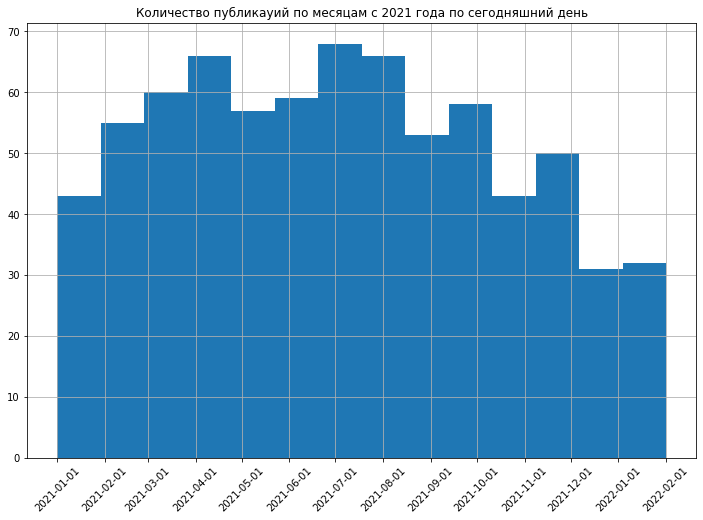

In [48]:
# Отфильтруем данные, чтобы туда попали только посты за 2021 и 2022 годы
df_hist_month = df[df["year_posts"] >=2021]
bins = df_hist_month.year_month.unique()


fig, ax = plt.subplots(figsize=(12,8))

ax.hist(x=df_hist_month.year_month, bins=len(bins))
plt.xticks(bins, rotation=45)

plt.title("Количество публикауий по месяцам с 2021 года по сегодняшний день")
plt.grid()
plt.show()